# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pictures\pic1.png"/>

Then you will want to run the above command:

<img src="pictures\pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
from dateutil import rrule
from datetime import datetime
from time import time
from dateutil.parser import parse
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, fbeta_score
import visuals as vs
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from pandas import Series
%matplotlib inline



In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Define functions which will be used later：

In [3]:
# merge "offer id" and "offer_id" columns into one column.
# offer id和offer_id这两列重复了，需要把他们合并：如果offer_id为空，则把offer id的值填到offer_id里
def combine_offer_id(a, b):
    if pd.isna(b):
        return a
    else:
        return b
    
    
# 创建判断行为是否发生在有效期的函数
# decide whether activity happens during the offer duration period
def action_in_valiperd(receive_time, duration, action_time):
    if action_time >= receive_time and action_time <= receive_time+duration*24:
        return 1
    else:
        return 0
    
    
# 创建判断顾客的行为是否收到offer的影响
# Decide whether user activity are effected by the offer
def offer_has_effect(is_viewed, is_used, has_trans, offer_type):
    if is_viewed == 0: 
        return 0   # 只要用户没看过offer，都算没影响
    else:
        if has_trans == 0:
            return 0   # 如果被看过，但是没有交易，也算没影响 （没有交易，但是用券的情况应该不存在）
        else: 
            if is_used == 1:
                return 1 # 被看过，有交易，且用券，说明有影响
            else: 
                if offer_type == 'informational':
                    return 1 # 被看过，有交易，没用券，但是是消息类的推送（不可能用券），说明有影响
                else:
                    return 0 # 非消息类，即使有交易，没用券也认为没影响

# 根据trans_effect['in_valiperd']和trans_effect['is_effect']两个字段，来判断该交易是否收到offer影响。
# Decide whether trans is effected by offer based on trans_effect['in_valiperd'] and trans_effect['is_effect'] 
def is_trans_effect(in_valiperd, is_effect):
    if pd.isna(is_effect) == False and pd.isna(in_valiperd) == False:
        return in_valiperd*is_effect
    else:
        return 0

    
# 给顾客的income分类
# categorize customer income
def income_type(x):
    if pd.isna(x):
        return x
    elif x <= 50000:
        return "0~50000"
    elif x > 50000 and x <= 100000:
        return "50001~100000"
    elif x > 100000 and x <= 150000:
        return "100000~150000"
    elif x > 150000 and x <= 200000:
        return "150000~200000"
    else:
        return ">200000"
    
    
# 给顾客的年龄age分类
# categorize customer age
def age_type(x):
    if pd.isna(x) or x == 118:
        return "None"
    elif x < 10:
        return "0~9y"
    elif x >= 10 and x < 20:
        return "10~19y"
    elif x >= 20 and x < 30:
        return "20~29y"
    elif x >= 30 and x < 40:
        return "30~39y"
    elif x >= 40 and x < 50:
        return "40~49y"
    elif x >= 50 and x < 60:
        return "50~59y"
    elif x >= 60 and x < 70:
        return "60~69y"
    elif x >= 70 and x < 80:
        return "70~79y"
    elif x >= 80 and x < 90:
        return "80~89y"
    elif x >= 90 and x < 100:
        return "90~99y"
    else:
        return ">100y"
    
# 根据x的条件，用y赋值
# use x to give a value from y
def filter_x(x, y):
    if x == 1:
        return y
    else:
        return 0
    
    
# 计算日期x（int：20170421）距离当前日期有多少天
# calculate the days from x to now
def days_from_x(x):
    if pd.isna(x):
        return x
    else:
        now = datetime.now()
        try: 
            start_date = parse(str(x))
            #datediff = rrule.rrule(freq = rrule.DAILY,dtstart=start_date,until=now)   
            #return datediff.count()   #这个计算起来速度太慢，可能是因为有count的原因
            datediff = now - start_date
            return datediff.days
        except:
            return np.nan

        
# 把天数按照半年一档来划分（days_type）
# categorize the days (180 days as step)
def days_type(x):
    if pd.isna(x):
        return x
    else:
        return int(x/180)

        
# 转化int日期x（int：20170421）到datetime （废弃）
# invert int date into datetime
def x_to_datetime(x):
    if pd.isna(x):
        return x
    else:
        try: 
            start_date = parse(str(x))
            return start_date
        except:
            return np.nan

## Data cleaning:
### Clean the data: deal with transcript.value

In [4]:
# 把value的值拆成多个列（根据字典里的类型）
# Based on the dictionary type, seperate the transcript.value into different columns
transcript_value_s = transcript['value'].apply(pd.Series)

# offer id和offer_id这两列重复了，需要把他们合并：如果offer_id为空，则把offer id的值填到offer_id里
transcript_value_s['offer_id']=transcript_value_s.apply(lambda transcript_value_s: combine_offer_id(transcript_value_s['offer id'],transcript_value_s['offer_id']),axis=1)

# 去掉多余的offer id列
transcript_value = transcript_value_s.drop(['offer id'], axis=1)

#transcript_value.head()

# 把加工好的transcript_value合并到transcript表后面
# Merge the transcript_value into transcript
transcript_new = pd.concat([transcript, transcript_value], axis=1, join_axes=[transcript.index])

# check how many types of event：
# - offer received
# - offer viewed
# - transaction
# - offer completed
transcript_new.drop_duplicates(['event'])

,event,person,time,value,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001},0.83,NaN,NaN
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,NaN,2906b810c7d4411798c6938adc9daaa5,2.0


### Refine portfolio and profile table for later use

In [5]:
# 重命名id列，使后面的merge更方便
# Rename the "id" to "offer_id" in portfolio table
portfolio.rename(columns={'id':'offer_id'},inplace=True) 
# 重命名id列，使后面的merge更方便
# Rename the "id" to "person_id" in profile table
profile.rename(columns={'id':'person_id'},inplace=True) 

# 给顾客的income分类
# categorize customer income
profile['income_type']=profile.apply(lambda profile: income_type(profile['income']),axis=1)
# 给顾客的年龄age分类
# categorize customer age
profile['age_type']=profile.apply(lambda profile: age_type(profile['age']),axis=1)
# 按照入会日期，计算每个顾客入会的时长
# Calculate how many days from the member join till now.
profile['membr_days'] = profile.apply(lambda profile: days_from_x(profile['became_member_on']),axis=1)
# 以半年（180天）为单位，划分顾客的入会时间
# categorize “membr_days” into types (180 days as a type).
profile['membr_days_type'] = profile['membr_days'].apply(lambda x: days_type(x)) 

profile.head()

,age,became_member_on,gender,person_id,income,income_type,age_type,membr_days,membr_days_type
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,NaN,None,1135,6
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,100000~150000,50~59y,982,5
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,NaN,None,620,3
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,50001~100000,70~79y,1049,5
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,None,962,5


# A. Analysis part
## 1. Calculate whether each person was effected by each offer (Multi Reaction)
one person can receive one offer for many times, but not act the same each time, so this table record each reaction.

In [6]:
# 1.1.1 把收到offer到行为单独提取出来
# 1.1.1 Bring out the offer receive activities from transcript_new
offer_received = transcript_new[transcript_new['event'] == 'offer received'].loc[:,['person','offer_id','time']]
offer_received.rename(columns={'time':'receive_time','person':'person_id'},inplace=True) 

# 1.1.2 关联portfolio表，取得券的有效期
# 1.1.2 join portfolio，get the offer duration time
offer_received = pd.merge(offer_received, portfolio, how='left', on=['offer_id'])


# 1.2.1 把offer view的行为单独提取出来
# 1.2.1 Bring out the offer viewed activities from transcript_new
offer_viewed = transcript_new[transcript_new['event'] == 'offer viewed'].loc[:,['person','offer_id','time']]
offer_viewed.rename(columns={'time':'view_time','person':'person_id'},inplace=True) 

# 1.2.2 收到offer到行为左连接view的行为，来计算多少收到offer后被查看了。（如果只有view行为，没有收到行为，理论上不应该，这里当作脏数据删除了）
# 1.2.2 received activity join viewed activity
offer_received = pd.merge(offer_received, offer_viewed, how='left', on=['person_id','offer_id'])

# 1.2.3 添加一列，判断在有效期内是否有view发生（注意：一条offer的推送可能关联多个view的行为，这里判断每条view行为是否在有效期内）
# 1.2.3 within the received offer, how many of them been viewed in the duration time period
offer_received['is_viewed']=offer_received.apply(lambda offer_received: 
                                                 action_in_valiperd(offer_received['receive_time'], 
                                                                    offer_received['duration'], 
                                                                    offer_received['view_time']),axis=1)

# 1.2.4 得到每次用户收到offer后，是否在有效期内阅读了。（注意：一条offer用户可能阅读多次，这里统一只计为1-是否阅读；如果后续需要区分阅读次数，可以再改）
# 1.2.4 user might view the offer for many times, here I consider if view happened once, it is viewed (no matter the times)
offer_received = offer_received.groupby(['person_id','offer_id','receive_time','duration'],as_index=False)['is_viewed'].max()



# 1.3.1 把offer use的行为单独提取出来（跟view的行为处理方法一致）
# 1.3.1 Bring out the offer use (complete) activities from transcript_new
offer_completed = transcript_new[transcript_new['event'] == 'offer completed'].loc[:,['person','offer_id','time','reward']]
offer_completed.rename(columns={'time':'use_time','person':'person_id'},inplace=True) 

# 1.3.2 收到offer到行为左连接view的行为，来计算多少收到offer后被查看了。（如果只有view行为，没有收到行为，理论上不应该，这里当作脏数据删除了）
# 1.3.2 received activity join use activity
offer_received = pd.merge(offer_received, offer_completed, how='left', on=['person_id','offer_id'])

# 1.3.3 添加一列，判断在有效期内是否有use发生（注意：一条offer的推送也可能关联多个use的行为，不一定在同一有效期）
# 1.3.3 within the received offer, how many of them been used in the duration time period
offer_received['is_used']=offer_received.apply(lambda offer_received: 
                                                 action_in_valiperd(offer_received['receive_time'], 
                                                                    offer_received['duration'], 
                                                                    offer_received['use_time']),axis=1)


# 1.3.4 得到每次用户收到offer后，是否在有效期内使用了。（注意：原则上一次推送的offer，只能在有效期内被使用一次，
#      但是也有可能两次推送同样的offer，且有效期重叠，这样就会得到每条推送都关联了2条使用记录，且reward金额可能不同。
#      但是，根据现有数据，没有办法区分哪条use是对应哪条推送的，所以统一都取一条最大的）
# 1.3.4 based on the receive time, decide whether this offer sent has been finally used.
offer_received = offer_received.groupby(['person_id','offer_id','receive_time','duration','is_viewed'],as_index=False)['is_used'].max()

#offer_received = offer_received.groupby(['person_id','offer_id','receive_time','duration','is_viewed'],as_index=False)['is_used','reward'].max()
# 注意：使用max有一个问题，就是选取的是每一列的最大值，而不是选取最大值的那一行，也就是说只能在选取单列的最大值的时候才是准确的.
#      所以如果有2条以上使用记录，那么这个reward的金额可能不是真正用那一张的金额



# 1.4.1 把transaction的“交易”行为单独提取出来（这是每个顾客所有的交易记录）
# 1.4.1 Bring out the transaction activities from transcript_new
transaction_log = transcript_new[transcript_new['event'] == 'transaction'].loc[:,['person','time','amount']]
transaction_log.rename(columns={'time':'transaction_time','person':'person_id'},inplace=True) 

# 1.4.2 收到offer到行为左连接交易行为，来计算offer的有效期内，是否有交易产生。（这里只看和收到offer的人有关的交易数据）
# 1.4.2 received activity join transaction activity
offer_received = pd.merge(offer_received, transaction_log, how='left', on=['person_id'])

# 1.4.3 添加一列，判断在有效期内是否有use发生（注意：一条offer的推送也可能关联多个use的行为，不一定在同一有效期）
# 1.4.3 within the received offer, whether there is transaction happened in the duration time period
offer_received['has_trans']=offer_received.apply(lambda offer_received: 
                                                 action_in_valiperd(offer_received['receive_time'], 
                                                                    offer_received['duration'], 
                                                                    offer_received['transaction_time']),axis=1)

# 1.4.4 得到每次用户收到offer后，是否在有效期内有交易。（注意：原则上如果有交易，不一定用券；但是用券了，一定有交易）
# 1.4.4 based on every time user receive the offer, whether he/she has an transaction during the duration time period.
offer_received = offer_received.groupby(['person_id','offer_id','receive_time','duration','is_viewed','is_used'],as_index=False)['has_trans'].max()
offer_received.head()

,person_id,offer_id,receive_time,duration,is_viewed,is_used,has_trans
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576,7,0,1,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,4,1,0,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,3,1,0,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408,5,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504,10,1,1,1


In [7]:
# 1.5.1 再次关联portfolio表，取得券的类型（后续判断会用到）
# 1.5.1 join portfolio again, to get the offer types (later will be used)
offer_received = pd.merge(offer_received, portfolio, how='left', on=['offer_id'])
offer_received = offer_received.drop(['duration_y'], axis=1)
offer_received.rename(columns={'duration_x':'duration'},inplace=True) 

# 1.5.2 添加一列，判断offer对于顾客的影响
# 1.5.2 decide whether the offer effect customers
offer_received['is_effect']=offer_received.apply(lambda offer_received: 
                                                 offer_has_effect(offer_received['is_viewed'], 
                                                                    offer_received['is_used'], 
                                                                    offer_received['has_trans'],
                                                                    offer_received['offer_type']),axis=1)

# 1.5.3 增加一列is_receive，全部赋值为1，因为所有记录都是收到offer的。这个方便后续的groupby计算
# 1.5.3 add a is_receive columns (all set to 1), to calculate effect_score later
offer_received['is_receive'] = 1
offer_received.head()

,person_id,offer_id,receive_time,duration,is_viewed,is_used,has_trans,channels,difficulty,offer_type,reward,is_effect,is_receive
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576,7,0,1,1,"[web, email, mobile]",10,discount,2,0,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,4,1,0,1,"[web, email, mobile]",0,informational,0,1,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,3,1,0,1,"[email, mobile, social]",0,informational,0,1,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408,5,1,1,1,"[web, email, mobile, social]",5,bogo,5,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504,10,1,1,1,"[web, email, mobile, social]",10,discount,2,1,1


In [ ]:
#######------------到这里，第一张宽表就做好了。---------------------

In [8]:
# Data-Check：
# whether exist this situation: offer is used, but no transaction（logically this situation shouldn't exist）
offer_received.query('is_used == 1 and has_trans == 0')
# Result: NO such situation, it means the data is correct. 

,person_id,offer_id,receive_time,duration,is_viewed,is_used,has_trans,channels,difficulty,offer_type,reward,is_effect,is_receive


## 2. Calculate whether each person was effected by each offer (Summarized Reaction)
one person can receive one offer for many times, but not act the same each time, so this table summarized each reaction to get the average effect_score. i.e. if a person receive the same offer 3 times, effected 2 times, then the effect_score = 2/3. 

In [9]:
# 2.1 计算出每个顾客对于每种offer的反应
# 2.1 Calculate every customers's response (effect_score) to every offer
user_offer_reaction = offer_received.groupby(['person_id','offer_id'],as_index=False)['is_effect','is_receive'].sum()

user_offer_reaction['effect_score'] = user_offer_reaction['is_effect']/user_offer_reaction['is_receive']
user_offer_reaction.head()

,person_id,offer_id,is_effect,is_receive,effect_score
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,1,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,1,1.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,1,1.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1.0


In [10]:
# --------------这个表后面Model2会用到-----------------
# ------------This table will be used in Model 2 later -----------

## 3. Transaction distribution for each person, how many transactions were effected by offer.
Calculate below metrics for each person:
- total order count
- total order amount
- How many orders happened during offer period
- how many orders were effected by offer
- effected order amount...

In [10]:
# 注意：这里没有交易id，需要把index作为交易的唯一id，因为可能存在同一个人，同一时间，同等金额的交易。
# Set the index as unique trans_id, because there is no transaction unique id. 
transaction_log['trans_id'] = transaction_log.index

# 所有交易行为左连接第一张宽表（每个顾客对于每个收到的offer的反应，同一个offer可能收到多次）
# all transaction activities left join offer_received
trans_effect = pd.merge(transaction_log, offer_received, how='left', on=['person_id'])

# 添加一列，判断该交易是否在offer的有效期内（注意：一条交易可能关联多条offer推送的行为，且可能有多条都在有效期内）
# If transaction happened during offer duration period. (one trans might link to multiple offer sent activity, and maybe many are within duration period)
trans_effect['in_valiperd']=trans_effect.apply(lambda trans_effect: 
                                                 action_in_valiperd(trans_effect['receive_time'], 
                                                                    trans_effect['duration'], 
                                                                    trans_effect['transaction_time']),axis=1)

# 用in_valiperd和is_effect结合看该笔交易是否收到offer的影响： 只有is_effect和in_valiperd同时为1的情况下，才算。
# whether a transaction is effected by offer (one transaction could still link to multiple offers)
trans_effect['trans_effect'] = trans_effect.apply(lambda trans_effect: 
                                                 is_trans_effect(trans_effect['in_valiperd'], 
                                                                    trans_effect['is_effect']),axis=1)

# 得到每笔交易是受到offer影响
# calculate whether every transaction is effected (if one linked offer is effected, then it's effected)
trans_effect = trans_effect.groupby(['trans_id','person_id','transaction_time','amount'],as_index=False)['in_valiperd','trans_effect'].max()

trans_effect.head()


,trans_id,person_id,transaction_time,amount,in_valiperd,trans_effect
0,12654,02c083884c7d45b39cc68e1314fec56c,0,0.83,1,0.0
1,12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,1,1.0
2,12659,54890f68699049c2a04d415abc25e717,0,13.23,0,0.0
3,12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,1,1.0
4,12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,1,1.0


In [11]:
# 计算每个顾客的客单价，受影响的订单数，不受影响的订单数，受影响的订单金额，不受影响的订单金额
# Calculate "order count", "effect orders", "effected amount"
user_summary = trans_effect
user_summary['trans_cnt'] = 1
user_summary['effect_amount'] = user_summary.apply(lambda user_summary: 
                                                 filter_x(user_summary['trans_effect'], 
                                                          user_summary['amount']),axis=1)


# 按照人，来统计交易情况
# aggregate based on person_id
user_summary = user_summary.groupby(['person_id'],as_index=False)['trans_cnt','amount','in_valiperd','trans_effect','effect_amount'].sum()


# 结合顾客的属性，分析哪些顾客容易受offer影响
# join the customer attributes, for analysis
user_summary = pd.merge(user_summary, profile, how='left', on=['person_id'])
user_summary.head()

,person_id,trans_cnt,amount,in_valiperd,trans_effect,effect_amount,age,became_member_on,gender,income,income_type,age_type,membr_days,membr_days_type
0,0009655768c64bdeb2e877511632db8f,8,127.60,8,8.0,127.60,33,20170421,M,72000.0,50001~100000,30~39y,1067,5
1,00116118485d4dfda04fdbaba9a87b5c,3,4.09,0,0.0,0.00,118,20180425,None,NaN,NaN,None,698,3
2,0011e0d4e6b944f998e987f904e8c1e5,5,79.46,4,4.0,65.97,40,20180109,O,57000.0,50001~100000,40~49y,804,4
3,0020c2b971eb4e9188eac86d93036a77,8,196.86,6,5.0,115.57,59,20160304,F,90000.0,50001~100000,50~59y,1480,8
4,0020ccbbb6d84e358d3414a3ff76cffd,12,154.05,11,11.0,137.78,24,20161111,F,60000.0,50001~100000,20~29y,1228,6


In [12]:
user_summary.to_excel('user_summary.xlsx')

# B. Modeling part
In the modeling part, I built 2 models, and finally use these 2 models to decide whether we push offer to a new customer, and which offer is best for him/her. 
## 1. Model 1：user machine learning to predict whether a customer will be effected by an offer.
### 1.1 Preparing Data：
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as preprocessing. There might be some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

Based on previous processed table (offer_received),  adding customer and offer attributes data, to get records on each offer received by what customers and whether this offer effected this user at that time. (as features and target data)

根据第一张宽表的内容，加入顾客的属性，以及券的属性，得到每种顾客对于每种券，是否会受到影响

In [12]:
# 1.1.1 investigating of the dataset to see how many individuals fit into either group (effected, Not_effected)
# 1.1.1 查看数据集中，is_effect的记录数，占比。1和0的条数是否偏差太大

n_records = len(offer_received)

n_effect = len(offer_received[offer_received['is_effect'] == 1])

n_not_effect = len(offer_received[offer_received['is_effect'] == 0])

effect_percent = n_effect/n_records*100

# Print the results
print("Total number of records: {}".format(n_records))
print("effected records: {}".format(n_effect))
print("not effected records: {}".format(n_not_effect))
print("Percentage of effected records: {}%".format(effect_percent))

# 还好，占比还算均匀，没有1特别多，或者0特别多的情况。


# 1.1.2 准备数据 - 加入顾客的属性，以及券的属性
# 1.1.2 Preparing data - add customer and offer attributes

user_offer_effect = offer_received.loc[:,['person_id','offer_id','duration','difficulty','reward','offer_type','is_effect']] 

# 加入顾客的属性
user_offer_effect = pd.merge(user_offer_effect, profile, how='left', on=['person_id'])

# 选取后续模型用到的列
user_offer_effect = user_offer_effect.loc[:,['age','gender','income','membr_days','duration','difficulty','reward','offer_type','is_effect']] 


# 1.1.3 Split the data into features and target label
effect_raw = user_offer_effect['is_effect']
features_raw = user_offer_effect.drop('is_effect', axis = 1)
print(effect_raw.shape)
print(features_raw.shape)


# 1.1.5 One-hot encode 'gender' and 'offer_type' using pandas.get_dummies()
features_onehot = pd.get_dummies(features_raw)
#features_onehot.head()

# effect_raw 本来就是0，1的列，不用处理

# 1.1.6 查看数据集里是否有缺失值
# 1.1.6 Check if there is NaN value
#features_onehot.isnull().sum(axis=0)
#effect_raw.isnull().sum(axis=0)


# 1.1.7 处理缺失值
# Deal with NaN value
# 把income的值单独提出来
income = features_onehot['income']
income = income.dropna()

# 计算income的平均值
print(np.mean(income))
#计算income的中位数
print(np.median(income))
# 计算income的众数
gm = pd.Series(data=income)
income_mode = gm.mode()[0]
print(income_mode)

# 用众数替换掉income里掉NaN
# use mode value to replace the NaN value
values = {'income': income_mode}
features_no_na = features_onehot.fillna(value=values)

# 检查处理后还有没有空值
#features_no_na.isnull().sum(axis=0)


# 1.1.4 Normalizing Numerical Features
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'membr_days', 'income', 'duration', 'difficulty','reward']

# 进行标准化计算 （值控制在0～1之间）
features_final = pd.DataFrame(data = features_no_na)
features_final[numerical] = scaler.fit_transform(features_no_na[numerical])

# Show an example of a record with scaling applied
#display(features_final.head())


# 1.1.8 准备训练集和测试集 Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    effect_raw, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Total number of records: 76277
effected records: 34625
not effected records: 41652
Percentage of effected records: 45.39376220879164%
(76277,)
(76277, 8)
65371.6184719
64000.0
73000.0
Training set has 61021 samples.
Testing set has 15256 samples.


### 1.2 Building and Evaluating Model Performance：
#### Naive Predictor Performance
If we chose a model that always predicted a record as "effected", what would that model's accuracy and F-score be on this dataset? I use the code cell below and assign the results to 'accuracy' and 'fscore' to be used later.

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

**Note** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally the base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place we could start from.

In [13]:
# 1.2.1 Calculate Naive Predictor 如果预测结果是永真（都是1），那么accuracy and F-score 是多少？
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# Calculate accuracy, precision and recall
TP = np.sum(effect_raw)
FP = effect_raw.count() - TP
TN = 0
FN = 0
accuracy = (TP+TN)/effect_raw.count()
recall = TP/(TP+FN)
precision = TP/(TP+FP)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta = 0.5
fscore = (1+beta*beta)*(precision*recall)/(beta*beta*precision + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.4539, F-score: 0.5096]


#### Supervised Learning Models
I choose below 3 algorithms to perform the model and see which is the best. These 3 can all be used to classify and predict data in categories. 
   * Support Vector Machines (SVM)
   * Gaussian Naive Bayes (GaussianNB)
   * Logistic Regression

After choosing models, we need to **Creating a Training and Predicting Pipeline** to train the data using input algorithm (as an input parameter) and predict data to see the model result. We can do this one by one, but building a pipeline will save much code and make the steps more clearly.


In [14]:
# 1.2.2 Creating a Training and Predicting Pipeline

# 创建预测模型 Pipeline （可以根据不同的model，来测试结果）
def train_predict(learner, sample_size, first_n_train, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - first_n_train: first n training samples, for accuracy & F1-score on training subset 
       - X_train: features training set
       - y_train: y training set
       - X_test: features testing set
       - y_test: y testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first n training samples(X_train[:]) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:first_n_train])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first n training samples which is y_train[:first_n_train]
    results['acc_train'] = accuracy_score(y_train[:first_n_train], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first n training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:first_n_train], predictions_train, beta = 0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

GaussianNB trained on 610 samples.
GaussianNB trained on 6102 samples.
GaussianNB trained on 61021 samples.
LogisticRegression trained on 610 samples.
LogisticRegression trained on 6102 samples.
LogisticRegression trained on 61021 samples.
LinearSVC trained on 610 samples.
LinearSVC trained on 6102 samples.
LinearSVC trained on 61021 samples.


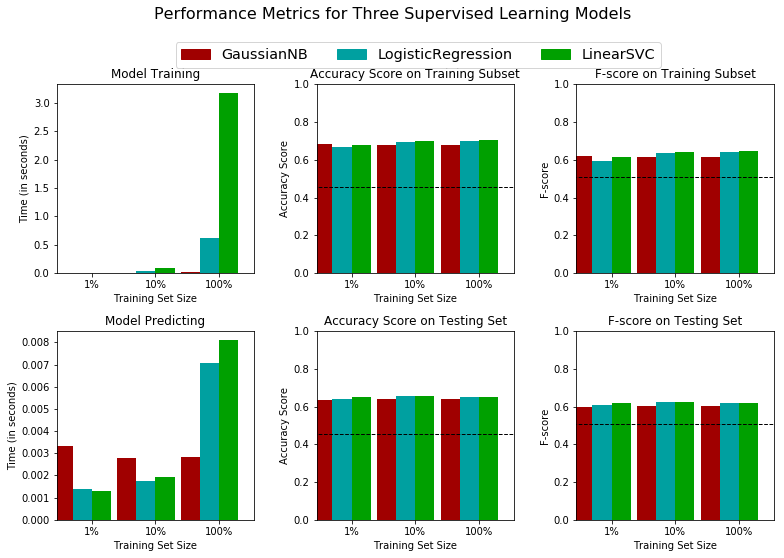

In [15]:
# 1.2.3 Initial Model Evaluation

# 用不同的model训练数据集，得到结果的分析图表
# 这里选择3种模型：
# GaussianNB
# svm
# LogisticRegression

# Initialize the three models
clf_A = GaussianNB()
clf_B = LogisticRegression(random_state=1)
clf_C = svm.LinearSVC(random_state=1)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(len(y_train)*0.1)
samples_1 = int(len(y_train)*0.01)

# set first n training samples
first_n_train = 300

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, first_n_train, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

#### Choosing the Best Model
* LinearSVC has the highest F Score on the training subset, but almost the same score as Logistic Regression in testing set. Logistic Regression's accuracy is higher when 1% or 10% of the testing data is used.
* GaussianNB is the fastest in training, but slowest in prediction. LinearSVC cost most time when training, but fewest time when prediction. Logistic Regression perform best on time when using 100% of model predicting. 
* From the result, looks like GaussianNB is not suitable for the data - cost too much time during training but the worst accuracy and F-score. 
* LinearSVC and LogisticRegression's accuracy and F-score result is pretty much similar, but consider the training time (LinearSVC is much longer than LG), Logistic Regression looks better overall.

So I choose Logistic Regression.


#### 1.2.4 Model Tuning
GridSearchCV has some changes in the latest sklearn version，here is the latest documents:
- Import [`sklearn.model_selection.GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).

In [16]:
# 1.2.4 Model Tuning

# Initialize the classifier
clf = LogisticRegression(random_state=1)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'class_weight': [None,'balanced',{0:0.2,1:0.8},{0:0.45,1:0.55},{0:0.48,1:0.52},{0:0.5,1:0.5},{0:0.52,1:0.48},{0:0.55,1:0.45},{0:0.58,1:0.42},{0:0.6,1:0.4}], 
              'solver': ['liblinear', 'newton-cg', 'lbfgs', 'saga'],
             'max_iter':[200, 500]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the Unoptimized and Optimized model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print(clf.get_params())
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print(best_clf.get_params())

Unoptimized model
------
Accuracy score on testing data: 0.6523
F-score on testing data: 0.6211
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 1, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Optimized Model
------
Final accuracy score on the testing data: 0.6559
Final F-score on the testing data: 0.6252
{'C': 1.0, 'class_weight': {0: 0.45, 1: 0.55}, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 200, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 1, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


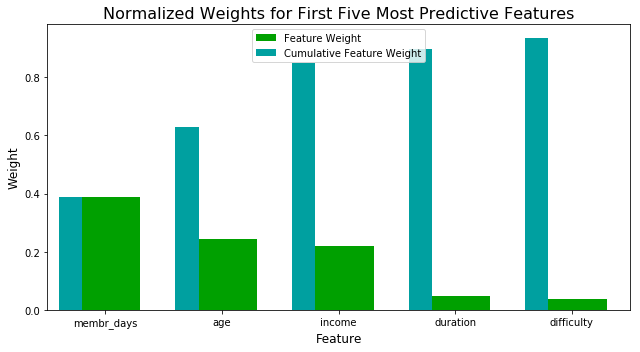

In [17]:
#### 1.2.5 Extracting Feature Importance (Optional)
#       看看哪些feature是重要的

# Train the supervised model on the training set using .fit(X_train, y_train)
model = RandomForestClassifier(random_state = 1).fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

In [18]:
#### 1.2.6 Feature Selection （Optional）
#  上面5个feature可以代表80%+的重要度，所以可以只用这5个feature来建模试试看，准确率是否有所下降

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.6559
F-score on testing data: 0.6252

Final Model trained on reduced data
------
Accuracy on testing data: 0.6277
F-score on testing data: 0.5965


## 2. Use Model1
### 2.1 Process new customer data for prediction.
Create new customers (with different attributes: age, gender, income...), then predict whether they will be effected by each offer. 

In [19]:
# 2.1.1 Create n new customers (with different attributes: age, gender, income...) 

# 注意：这里创建的新用户，假设每个属性都不为空。方便后续预测。在实际项目中，如果为空，要先处理下。

n_person = 2
new_person = pd.DataFrame({'age': np.random.randint(20, 70, n_person), 
                    'gender': np.random.choice(['M', 'F'], n_person), 
                    'income': np.random.randint(20000, 120000, n_person),
                    'membr_days': np.random.randint(600, 2400, n_person), # because our data is not very new, we don't have members which joined in nearest 2 years...
                    'key': 'key'})
new_person['p_id'] = range(len(new_person))
new_person

,age,gender,income,membr_days,key,p_id
0,37,M,33439,2394,key,0
1,45,M,69824,1295,key,1


In [20]:
# 2.1.2 Put the new customers with each offer together, to build the feature table for prediction

# 2.1.2 把需要预测的新用户属性，和每一张券做成一个feature df，预测该用户对于每一种券，是否可能有反应
# 在portfolio中加入一个key，为了后续做笛卡尔积运算
portfolio_1 = portfolio
portfolio_1['key'] = 'key'

# 把每个顾客的属性 和 所有的券都关联起来， 做成要预测的feature数据集
new_person_offer = pd.merge(new_person, portfolio_1, on = 'key')
display(new_person_offer)

# 选取模型用到的列
new_person_feature = new_person_offer.loc[:,['age','gender','income','membr_days','duration','difficulty','reward','offer_type']] 
display(new_person_feature)

,age,gender,income,membr_days,key,p_id,channels,difficulty,duration,offer_id,offer_type,reward
0,37,M,33439,2394,key,0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,37,M,33439,2394,key,0,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,37,M,33439,2394,key,0,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,37,M,33439,2394,key,0,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,37,M,33439,2394,key,0,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,37,M,33439,2394,key,0,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,37,M,33439,2394,key,0,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,37,M,33439,2394,key,0,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,37,M,33439,2394,key,0,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,37,M,33439,2394,key,0,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


,age,gender,income,membr_days,duration,difficulty,reward,offer_type
0,37,M,33439,2394,7,10,10,bogo
1,37,M,33439,2394,5,10,10,bogo
2,37,M,33439,2394,4,0,0,informational
3,37,M,33439,2394,7,5,5,bogo
4,37,M,33439,2394,10,20,5,discount
5,37,M,33439,2394,7,7,3,discount
6,37,M,33439,2394,10,10,2,discount
7,37,M,33439,2394,3,0,0,informational
8,37,M,33439,2394,5,5,5,bogo
9,37,M,33439,2394,7,10,2,discount


In [21]:
# 2.1.3 Normalizing Numerical Features

# 进行标准化计算 （值控制在0～1之间）之前已经fit了，所以这里只需要标准化数据而不需要再次拟合数据
new_person_feature[numerical] = scaler.transform(new_person_feature[numerical])

# Show an example of a record with scaling applied
#display(new_person_feature)


# 2.1.4 One-hot encode 'gender' and 'offer_type' using pandas.get_dummies()

new_person_feature = pd.get_dummies(new_person_feature)

_, new_feature = features_onehot.align(new_person_feature, join='left', axis=1, fill_value=0)

new_feature

,age,income,membr_days,duration,difficulty,reward,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount,offer_type_informational
0,0.19,0.038211,0.980801,0.571429,0.50,1.0,0,1,0,1,0,0
1,0.19,0.038211,0.980801,0.285714,0.50,1.0,0,1,0,1,0,0
2,0.19,0.038211,0.980801,0.142857,0.00,0.0,0,1,0,0,0,1
3,0.19,0.038211,0.980801,0.571429,0.25,0.5,0,1,0,1,0,0
4,0.19,0.038211,0.980801,1.000000,1.00,0.5,0,1,0,0,1,0
5,0.19,0.038211,0.980801,0.571429,0.35,0.3,0,1,0,0,1,0
6,0.19,0.038211,0.980801,1.000000,0.50,0.2,0,1,0,0,1,0
7,0.19,0.038211,0.980801,0.000000,0.00,0.0,0,1,0,0,0,1
8,0.19,0.038211,0.980801,0.285714,0.25,0.5,0,1,0,1,0,0
9,0.19,0.038211,0.980801,0.571429,0.50,0.2,0,1,0,0,1,0


### 2.2 Predict new customers data using Model 1

In [22]:
# 预测新的数据，并转换为dataframe格式
# use best_clf from Model 1 to predict newly generate features
new_predict = best_clf.predict(new_feature)
new_predict_series = Series(new_predict)
predict_effect = new_predict_series.to_frame(name='predict_effect')

# 把预测结果和之前的new_person_offer结合，获取personid和offerid的信息（注意：预测结果的index一定不能乱）
# join back the new_person_offer to get person ids (p_id) and offer_id
model1_result = pd.merge(new_person_offer, predict_effect, on = new_person_offer.index)

# 只选取预测结果相关的列
model1_result = model1_result.loc[:,['p_id','offer_id','predict_effect']] 

model1_result

,p_id,offer_id,predict_effect
0,0,ae264e3637204a6fb9bb56bc8210ddfd,1
1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,1
2,0,3f207df678b143eea3cee63160fa8bed,1
3,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
4,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0
5,0,2298d6c36e964ae4a3e7e9706d1fb8c2,1
6,0,fafdcd668e3743c1bb461111dcafc2a4,1
7,0,5a8bc65990b245e5a138643cd4eb9837,1
8,0,f19421c1d4aa40978ebb69ca19b0e20d,1
9,0,2906b810c7d4411798c6938adc9daaa5,1


Based on the result, we can see there is less difference between offers, new customers could be effected by multiple offers. Using this model, we cannot differentiate user preference between offers. So we need another model to do that. 

## 3. Model2: Build heuristics model that determine what offer we should send to customer 
根据用户的属性阶段，计算每种类型的用户，对于每种券的反应（effect_score）（更偏重于用户对于券的偏好）
### 3.1 Create a table to summarize how each user group (base on their demographics) response to each offer. 
创建一张表，用来查询每种类型的用户，对于券的反应

In [23]:
# 3.1.1 根据第一张宽表分析统计后，得到对每个用户对于每个offer（不一定是全部offer，因为可能没收到过）对反应
# 3.1.1 we already have every customers to every offer's reponse (effected or not) in user_offer_reaction table.
# user_offer_reaction.head()


# 3.1.2 加入顾客的属性
# 3.1.2 add customer attributes
userprofile_offer = pd.merge(user_offer_reaction, profile, how='left', on=['person_id'])
#userprofile_offer.head()


# 3.1.3 计算每种类型的用户，对于每种券的反应
# 3.1.3 calculate every types of customers to every offer's response(effect rate & effect score)
userpro_offer_summary = userprofile_offer.groupby(['age_type','gender','income_type','membr_days_type','offer_id'],as_index=False)['is_effect','is_receive'].sum()
userpro_offer_summary['effect_rate'] = userpro_offer_summary['is_effect']/userpro_offer_summary['is_receive']
userpro_offer_summary['effect_score'] = userpro_offer_summary['effect_rate']*userpro_offer_summary['is_receive']
userpro_offer_summary.head()

,age_type,gender,income_type,membr_days_type,offer_id,is_effect,is_receive,effect_rate,effect_score
0,10~19y,F,0~50000,3,3f207df678b143eea3cee63160fa8bed,0,3,0.0,0.0
1,10~19y,F,0~50000,3,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0.0,0.0
2,10~19y,F,0~50000,3,5a8bc65990b245e5a138643cd4eb9837,1,1,1.0,1.0
3,10~19y,F,0~50000,3,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0.0,0.0
4,10~19y,F,0~50000,3,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0.0,0.0


### 3.2 Recommend an offer based on customer's information (best offer from model 2)
根据用户信息，选择合适的券推送(这里最后选择出来的只有一个offer）

In [24]:
# 3.2.1 根据用户的属性，分类用户，然后根据3.1的表格来判定该给用户推送什么券
# 3.2.1 Based on user attributes and table 3.1, to decide which is the best offer for a person

def select_offer(age, gender, income, membr_days): 
    '''
    inputs:
       - age: i.e 56
       - gender: i.e "F"
       - income: i.e 54922 
       - membr_days: i.e. 1200
       
    Outputs:
       - recommend offer_id: best offer_id that user might like. 
                            If return "None" means no offer this person might like.(Don't need to push offer)
    '''
    
    # 把输入的属性，对应到分类上
    # calcuate which group this person belongs to
    age_c = age_type(age)
    income_c = income_type(income)
    membr_days_c = days_type(membr_days)
    
    # 找出用户对应的分类的reaction
    # find out how that group's reaction to each offer
    type_reaction = userpro_offer_summary.query('age_type == @age_c and gender == @gender and income_type == @income_c and membr_days_type == @membr_days_c')

    # 取出effect_score最大的那行（注意：可能是多行）
    # get the max effect_score rows (NOTE: might be more than 1 row)
    max_score = type_reaction['effect_score'].max()
    max_score_offer = type_reaction.query('effect_score == @max_score and effect_rate > 0.5') # 50%以上的反应才算有反应，这个阀值可以调
    #max_score_offer
    
    # 根据结果来判定给用户推送什么券：
    # Decide the offer:
    if len(max_score_offer) == 0:
        return None  # 如果历史记录里，该类型没有最优的score，则不用推送券
    elif len(max_score_offer) == 1:
        return max_score_offer.iloc[0]['offer_id']  # 如果只有一个最高分，则返回该最高分对应的offer_id
    else:
        # 选取receive最多的offer
        max_receive = max_score_offer['is_receive'].max()  
        recom_offer = max_score_offer.query('is_receive == @max_receive').iloc[0]['offer_id']  #还是可能有多个，选取第一个就可
        return recom_offer
    

    
# 使用之前创建的新用户信息new_person，根据Model2，预测该给用户推送什么券。
# user function above to decide the recommended offer
model2_result = new_person
model2_result['recom_offer'] = new_person.apply(lambda new_person: select_offer(new_person['age'],
                                                                     new_person['gender'],
                                                                     new_person['income'],
                                                                     new_person['membr_days']),axis=1)
model2_result

,age,gender,income,membr_days,key,p_id,recom_offer
0,37,M,33439,2394,key,0,fafdcd668e3743c1bb461111dcafc2a4
1,45,M,69824,1295,key,1,2906b810c7d4411798c6938adc9daaa5


## 4. Combine the result from Model 1 and Model 2, final decide whether we should send offer to the customer, and what offer should be sent. 
结合Model1和Model2的结果，判定是否该为新用户推送券，以及推送什么券

In [25]:
# 4.1 把model1和model2的结果结合起来
# 4.1 Combine the result from Model1 and Model2
new_person_result = pd.merge(model1_result, model2_result, on = 'p_id')
new_person_result

,p_id,offer_id,predict_effect,age,gender,income,membr_days,key,recom_offer
0,0,ae264e3637204a6fb9bb56bc8210ddfd,1,37,M,33439,2394,key,fafdcd668e3743c1bb461111dcafc2a4
1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,1,37,M,33439,2394,key,fafdcd668e3743c1bb461111dcafc2a4
2,0,3f207df678b143eea3cee63160fa8bed,1,37,M,33439,2394,key,fafdcd668e3743c1bb461111dcafc2a4
3,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,37,M,33439,2394,key,fafdcd668e3743c1bb461111dcafc2a4
4,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,37,M,33439,2394,key,fafdcd668e3743c1bb461111dcafc2a4
5,0,2298d6c36e964ae4a3e7e9706d1fb8c2,1,37,M,33439,2394,key,fafdcd668e3743c1bb461111dcafc2a4
6,0,fafdcd668e3743c1bb461111dcafc2a4,1,37,M,33439,2394,key,fafdcd668e3743c1bb461111dcafc2a4
7,0,5a8bc65990b245e5a138643cd4eb9837,1,37,M,33439,2394,key,fafdcd668e3743c1bb461111dcafc2a4
8,0,f19421c1d4aa40978ebb69ca19b0e20d,1,37,M,33439,2394,key,fafdcd668e3743c1bb461111dcafc2a4
9,0,2906b810c7d4411798c6938adc9daaa5,1,37,M,33439,2394,key,fafdcd668e3743c1bb461111dcafc2a4


In [26]:
# 4.2 根据结合起来的结果，判定是否该给用户推送券，应该推送什么券
# 这里的条件我设置得比较严格，只有2个model都建议推送的时候才推送。这个条件可以根据实际情况更改（比如需要推送的人数比例之类）
# 4.2 Define a function to decide which offer should be sent to the person
# Here I use a strict rule: only if 2 models both suggested an offer, we will suggest to push that offer 
def combined_decision(offer_id, predict_effect, recom_offer): 
    '''
    inputs:
       - age: i.e 56
       - gender: i.e "F"
       - income: i.e 54922 
       - membr_days: i.e. 1200
       
    Outputs:
       - recommend offer_id: best offer_id that user might like. 
                            If return "None" means no offer this person might like.(Don't need to push offer)
    '''
    
    # 只有当offer_id == recom_offer的时候（2个model都认为该推送该offer的时候，才推送）
    if predict_effect == 0:
        return "no offer"
    else:
        if recom_offer == 'None':
            return "no offer"
        else:
            if offer_id == recom_offer:
                return recom_offer
            else:
                return "no offer"

            
# 4.3 运用这个逻辑，得到最终决定
# 4.3 use the function to get the final decision in 'offer_decision' column
new_person_result['offer_decision'] = new_person_result.apply(lambda new_person_result: 
                                                              combined_decision(new_person_result['offer_id'],
                                                                                new_person_result['predict_effect'],
                                                                                new_person_result['recom_offer']),axis=1)
new_person_result

,p_id,offer_id,predict_effect,age,gender,income,membr_days,key,recom_offer,offer_decision
0,0,ae264e3637204a6fb9bb56bc8210ddfd,1,37,M,33439,2394,key,fafdcd668e3743c1bb461111dcafc2a4,no offer
1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,1,37,M,33439,2394,key,fafdcd668e3743c1bb461111dcafc2a4,no offer
2,0,3f207df678b143eea3cee63160fa8bed,1,37,M,33439,2394,key,fafdcd668e3743c1bb461111dcafc2a4,no offer
3,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,37,M,33439,2394,key,fafdcd668e3743c1bb461111dcafc2a4,no offer
4,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,37,M,33439,2394,key,fafdcd668e3743c1bb461111dcafc2a4,no offer
5,0,2298d6c36e964ae4a3e7e9706d1fb8c2,1,37,M,33439,2394,key,fafdcd668e3743c1bb461111dcafc2a4,no offer
6,0,fafdcd668e3743c1bb461111dcafc2a4,1,37,M,33439,2394,key,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4
7,0,5a8bc65990b245e5a138643cd4eb9837,1,37,M,33439,2394,key,fafdcd668e3743c1bb461111dcafc2a4,no offer
8,0,f19421c1d4aa40978ebb69ca19b0e20d,1,37,M,33439,2394,key,fafdcd668e3743c1bb461111dcafc2a4,no offer
9,0,2906b810c7d4411798c6938adc9daaa5,1,37,M,33439,2394,key,fafdcd668e3743c1bb461111dcafc2a4,no offer


In [27]:
# 4.3 Get the final push list on customers and offers (Note: customers who are suggest not to send offer will NOT be listed here)

# 得到最终建议push offer的人的名单（不建议push的，不在名单里)
push_offer = new_person_result.query('offer_decision != "no offer"').loc[:,['p_id','offer_decision']]
push_offer

,p_id,offer_decision
6,0,fafdcd668e3743c1bb461111dcafc2a4
19,1,2906b810c7d4411798c6938adc9daaa5
